In [1]:
# load training result get from preprocess.py module

import json
with open('ad2Adv.json', 'r') as fp:
    ad2AdvStr = json.load(fp)

with open('ad2Cam.json', 'r') as fp:
    ad2CamStr = json.load(fp)

with open('finalDis2Doc.json', 'r') as fp:
    finalDis2DocStr = json.load(fp)
    
with open('finalDoc2Cate.json', 'r') as fp:
    finalDoc2CateStr = json.load(fp) 

with open('finalDoc2Topic.json', 'r') as fp:
    finalDoc2TopicStr = json.load(fp)  
    
with open('finalDoc2Meta.json', 'r') as fp:
    finalDoc2MetaStr = json.load(fp)  
    
with open('finalData.json', 'r') as fp:
    finalDataStr = json.load(fp) 

In [2]:
# convert str dict to value dict
ad2Adv = dict()
for each in ad2AdvStr:
    ad2Adv[float(each)] = float(ad2AdvStr[each])

ad2Cam = dict()
for each in ad2CamStr:
    ad2Cam[float(each)] = float(ad2CamStr[each])
    
finalDis2Doc = dict()
for each in finalDis2DocStr:
    finalDis2Doc[float(each)] = float(finalDis2DocStr[each])
    
finalDoc2Cate = dict()
for each in finalDoc2CateStr:
    finalDoc2Cate[float(each)] = float(finalDoc2CateStr[each])
    
finalDoc2Topic = dict()
for each in finalDoc2TopicStr:
    finalDoc2Topic[float(each)] = float(finalDoc2TopicStr[each])
    
finalDoc2Meta = dict()
for each in finalDoc2MetaStr:
    finalDoc2Meta[float(each)] = float(finalDoc2MetaStr[each])
    
finalData = dict()
for each in finalDataStr:
    finalData[float(each)] = eval(finalDataStr[each])

In [58]:
# --------------------------------------------------------- SVM  ---------------------------------------------------------

In [3]:
# split trian and test
trainData = dict()
testData = dict()
count = 0
threshold = 2782
for i in finalData:
    if count < 2782:
        trainData[i] = finalData[i]
    else:
        testData[i] = finalData[i]
    count += 1

In [4]:
# create ad2ClickTrain Dict()
ad2ClickTrain = dict()
for dis in trainData:
    for adTuple in trainData[dis]:
        adID = adTuple[0]
        adClick = adTuple[1]
        if adClick == 1:
            if adID not in ad2ClickTrain:
                ad2ClickTrain[adID] = adClick
            else:
                ad2ClickTrain[adID] += adClick

In [5]:
# create adv2ClickTrain Dict()
adv2Click = dict()
cam2Click = dict()
for each in ad2ClickTrain:
    adID = each
    adv = ad2Adv[adID]
    cam = ad2Cam[adID]
    if adv not in adv2Click:
        adv2Click[adv] = ad2ClickTrain[adID]
    else:
        adv2Click[adv] += ad2ClickTrain[adID] 
        
    cam = ad2Cam[adID]
    if cam not in cam2Click:
        cam2Click[cam] = ad2ClickTrain[adID]
    else:
        cam2Click[cam] += ad2ClickTrain[adID]      

# use all its features as its top feature
import operator
topAdvFeature = dict(sorted(adv2Click.iteritems(), key=operator.itemgetter(1), reverse=True)[:len(adv2Click)])
topCamFeature = dict(sorted(cam2Click.iteritems(), key=operator.itemgetter(1), reverse=True)[:len(cam2Click)])

# create theta values for SVM later
thetaAdvDict = dict()
thetaCamDict = dict()
topAdvFeatureKeys = topAdvFeature.keys()
topCamFeatureKeys = topCamFeature.keys()
for i in range(len(topAdvFeatureKeys)):
    thetaAdvDict[topAdvFeatureKeys[i]] = 0
for i in range(len(topCamFeatureKeys)):
    thetaCamDict[topCamFeatureKeys[i]] = 0

In [251]:
# implement SVM based on selected all adv features
import math
totalItr = 100
eta = 0.001 # step size
for itr in range(totalItr):
    for dis in trainData:
        for adTuple in trainData[dis]:
            adID = adTuple[0]
            y = adTuple[1]
            adv = ad2Adv[adID]
            cam = ad2Cam[adID]
            # use y = 1 and -1 to run logistic regression
            if y == 0:
                y = -1
                
#             # SVM    
#             # update thetaAdvDict for adv, x is 1 which is indicator of feature
#             if adv in topAdvFeature:
#                 if 1-y*thetaAdvDict[adv]*1 > 0:
#                     JDerivative = -y*1
#                 else:
#                     JDerivative = 0
#                 thetaAdvDict[adv] -= eta*JDerivative
#             # update thetaCamDict for cam, x is 1 which is indicator of feature
#             if cam in topCamFeature:
#                 if 1-y*thetaCamDict[cam]*1 > 0:
#                     JDerivative = -y*1
#                 else:
#                     JDerivative = 0
#                 thetaCamDict[cam] -= eta*JDerivative
            # logistic regression
#             update thetaAdvDict for adv, x is 1 which is indicator of feature
            if adv in topAdvFeature:
                if thetaAdvDict[adv] > 20 and y == -1:
                    hTheta = 0
                else:
                    hTheta = (1/(1+math.exp(-y*thetaAdvDict[adv]*1)))
                JDerivative = (hTheta - 1)*(y*1)
                thetaAdvDict[adv] -= eta*JDerivative
            # update thetaCamDict for cam
            if cam in topCamFeature:
                if thetaCamDict[cam] > 20 and y == -1:
                    hTheta = 0
                else: 
                    hTheta = (1/(1+math.exp(-y*thetaCamDict[cam]*1)))
                JDerivative = (hTheta - 1)*(y*1)
                thetaCamDict[cam] -= eta*JDerivative


In [261]:
# make prediction on test
from copy import deepcopy
import random    
maxHypo = 0
maxset = []
tie = 0
trueClick = 0
clickCount = 0
totalCount = 0
correctCount = 0

for dis in testData:
    totalCount = totalCount*0.9987
    # clear up value for next iteration
    trueClick = 0
    clickCount = 0
    maxHypo = -float('inf')
    Hypo = 0
    for adTuple in testData[dis]:
        # get value
        adID = adTuple[0]
        adv = ad2Adv[adID]
        cam = ad2Cam[adID]
        # get true click location
        y = adTuple[1]
        if y == 1:
            trueClick = clickCount
        # SVM
#         if adv in thetaAdvDict:
#             thetaAdv = thetaAdvDict[adv]
#             hypoAdv = thetaAdvDict[adv]*1
#         else:
#             hypoAdv = 0
#         if cam in thetaCamDict:
#             thetaCam = thetaCamDict[cam]
#             hypoCam = thetaCamDict[cam]*1
#         else:
#             hypoCam = 0
        # update thetaAdvDict for adv, x is 1 which is indicator of feature
        # logistic
        if adv in thetaAdvDict:
            thetaAdv = thetaAdvDict[adv]
            hypoAdv = 1/(1+math.exp(-thetaAdv*1))
        else:
            hypoAdv = 0
        if cam in thetaCamDict:
            thetaCam = thetaCamDict[cam]
            hypoCam = 1/(1+math.exp(-thetaCam*1))
        else:
            hypoCam = 0
        Hypo = hypoAdv + hypoCam 
        Hpyo = max(0, Hypo)
        if Hypo > maxHypo:
            maxHypo = Hypo
            maxset = []
            maxset.append(clickCount)
        elif Hypo == maxHypo:
            maxset.append(clickCount)
        clickCount += 1
    # make prediction: outer loop
    if len(maxset) == 1:
        predClick = maxset[0]
    else:
        predClick = random.sample(maxset, 1)
    if (predClick == trueClick):
        correctCount += 1
    totalCount += 1
print float(correctCount)/totalCount

0.457174618573


In [ ]:
# ---------------------------------------------- NN and do not use for now --------------------------------------------------

In [33]:
# prepare set x and y
import numpy as np
x = np.array
xTrainSet = []
yTrainSet = []
xTestSet = []
yTestSet = []
# this is only use for test
xTrainClickSet = []
yTrainClickSet = []
xTestClickSet = []
yTestClickSet = []
xTestNotClickSet = []
yTestNotClickSet = []

# 1 click and 1 not click count
clickCount = 0
nonClickCount = 0

countSplit = 0
splitThreshold = 2702
for disID in finalData:
    xSubSet = []
    ySubSet = []
    adClickIDTupleSet = finalData[disID]
    for adClickIDTuple in adClickIDTupleSet:
        adID = adClickIDTuple[0]
        clickID = adClickIDTuple[1]
        # from ad_id
        advID = ad2Adv[adID]
        camID = ad2Cam[adID]
        # docID key
        docID = finalDis2Doc[disID]
        # from display_id
        cateID = finalDoc2Cate[docID]
        topicID = finalDoc2Topic[docID]
        metaID = finalDoc2Meta[docID]
        # make subset for x
        xSubSet = [advID, camID, cateID, topicID, metaID]
        # make subset for y
        if (clickID == 0): # not click
            ySubSet = [1, 0]
        else:
            ySubSet = [0, 1] # click
        # train and test dict
        if (countSplit < splitThreshold):
            xTrainSet.append(xSubSet)
            yTrainSet.append(ySubSet) 
            if (ySubSet == [0, 1]) and clickCount == 0: # click
                xTrainClickSet.append(xSubSet)
                yTrainClickSet.append(ySubSet)
                clickCount += 1
            if (ySubSet == [1, 0]) and nonClickCount == 0: # not click
                xTrainClickSet.append(xSubSet)
                yTrainClickSet.append(ySubSet)
                nonClickCount += 1
        else:
            xTestSet.append(xSubSet)
            yTestSet.append(ySubSet) 
            if (ySubSet == [0, 1]): # click
                xTestClickSet.append(xSubSet)
                yTestClickSet.append(ySubSet)
            else:
                xTestNotClickSet.append(xSubSet)
                yTestNotClickSet.append(ySubSet)
    countSplit += 1
    clickCount = 0
    nonClickCount = 0

In [4]:
# train
# convert set x and y to matrix x and y
xTrain = np.array(xTrainSet, np.int32)
yTrain = np.array(yTrainSet, np.int32)
# convert set x and y to matrix x and y
xTrainClick = np.array(xTrainClickSet, np.int32)
yTrainClick = np.array(yTrainClickSet, np.int32)

# test
# convert set x and y to matrix x and y
xTest = np.array(xTestSet, np.int32)
yTest = np.array(yTestSet, np.int32)
# convert set x and y to matrix x and y
xTestClick = np.array(xTestClickSet, np.int32)
yTestClick = np.array(yTestClickSet, np.int32)
# convert set x and y to matrix x and y
xTestNotClick = np.array(xTestNotClickSet, np.int32)
yTestNotClick = np.array(yTestNotClickSet, np.int32)

In [5]:
# make dict for each display_id to matrix for passing to tensorflow for training
xTestDict = dict()
yTestDict = dict()
start = 0
count = 0
for i in range(len(xTest)-1):
    if xTest[i,2] != xTest[i+1,2]:
        xSubMatrix = xTest[start:i+1]
        ySubMatrix = yTest[start:i+1]
        xTestDict[count] = xSubMatrix
        yTestDict[count] = ySubMatrix
        count += 1
        start = i+1
        
xTrainDict = dict()
yTrainDict = dict()
start = 0
count = 0
for i in range(len(xTrain)-1):
    if xTrain[i,2] != xTrain[i+1,2]:
        xSubMatrix = xTrain[start:i+1]
        ySubMatrix = yTrain[start:i+1]
        xTrainDict[count] = xSubMatrix
        yTrainDict[count] = ySubMatrix
        count += 1
        start = i+1

In [6]:
# PCA for data visulization
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
# xTrainTranspose = xTrain.transpose()
# pca.fit(xTrainTranspose)
xTrainPCA = pca.fit_transform(xTrain)
#PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
#  svd_solver='auto', tol=0.0, whiten=False)
#xTrainPCA = pca.components_#.transpose()
# print(xTrainPCA)
print pca.explained_variance_ratio_

[  9.88605721e-01   1.05437800e-02   6.46889690e-04]


In [222]:
# # PCA for data visulization
# import numpy as np
# from sklearn.decomposition import PCA
# pca = PCA(n_components=3)
# xTrainTranspose = xTrain.transpose()
# pca.fit(xTrainTranspose)
# PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
#   svd_solver='auto', tol=0.0, whiten=False)
# xTrainPCA = pca.components_.transpose()
# print(xTrainPCA)

In [7]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

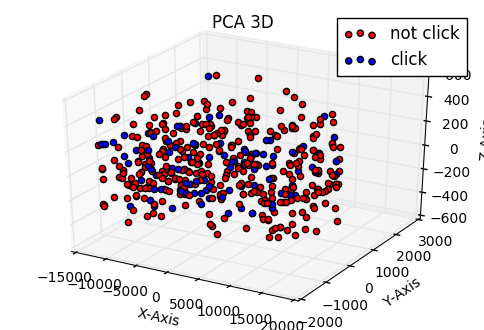

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

x = xTrainPCA[:,0]
y = xTrainPCA[:,1]
z = xTrainPCA[:,2]
labelCountClick = 0
labelCountnotClick = 0
for i in range(len(x)):
    if i%30 == 0:
        if yTrain[i][1] == 1 and labelCountnotClick == 0:
            ax.scatter(x[i],y[i],z[i],c='b',marker='o', label='click') # not click
            labelCountnotClick += 1
        elif labelCountClick == 0:
            ax.scatter(x[i],y[i],z[i],c='r',marker='o', label='not click') # click
            labelCountClick += 1
        else:
            if yTrain[i][1] == 1:
                ax.scatter(x[i],y[i],z[i],c='b',marker='o') # not click
            else:
                ax.scatter(x[i],y[i],z[i],c='r',marker='o') # click
            
ax.set_xlabel('X-Axis')
ax.set_ylabel('Y-Axis')
ax.set_zlabel('Z-Axis')
ax.set_title('PCA 3D')
plt.legend(loc='upper right')
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
# ax.set_zlim3d(-0.02, 0.03)                    
# ax.set_ylim3d(-0.02, 0.03)                    
# ax.set_xlim3d(-0.02, 0.03)     
plt.show()

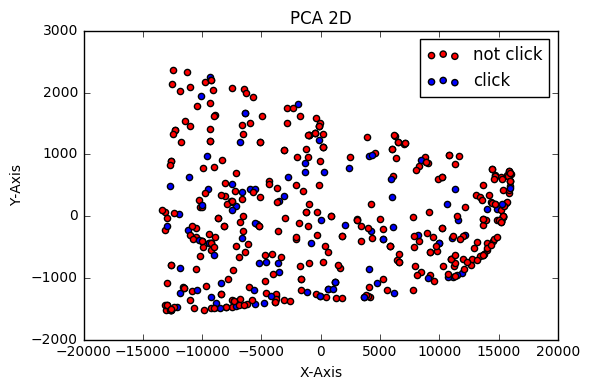

In [10]:
# 2d
pca = PCA(n_components=2)
# xTrainTranspose = xTrain.transpose()
# pca.fit(xTrainTranspose)
xTrainPCA = pca.fit_transform(xTrain)
#PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
#  svd_solver='auto', tol=0.0, whiten=False)
#xTrainPCA = pca.components_#.transpose()
# print(xTrainPCA)


import numpy as np
import matplotlib.pyplot as plt


x = xTrainPCA[:,0]
y = xTrainPCA[:,1]
labelCountClick = 0
labelCountnotClick = 0
for i in range(len(x)):
    if i%30 == 0:
        if yTrain[i][1] == 1 and labelCountnotClick == 0:
            plt.scatter(x[i],y[i],c='b',marker='o', label='click') # not click
            labelCountnotClick += 1
        elif labelCountClick == 0:
            plt.scatter(x[i],y[i],c='r',marker='o', label='not click') # click
            labelCountClick += 1
        else:
            if yTrain[i][1] == 1:
                plt.scatter(x[i],y[i],c='b',marker='o') # not click
            else:
                plt.scatter(x[i],y[i],c='r',marker='o') # click
            
# plt.set_xlabel('Y-Axis')
# plt.set_ylabel('Z-Axis')
# plt.set_title('PCA')
plt.legend(loc='upper right')
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
# ax.set_zlim3d(-0.02, 0.03)                    
# ax.set_ylim3d(-0.02, 0.03)                    
# ax.set_xlim3d(-0.02, 0.03)
plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')
plt.title('PCA 2D')
plt.show()

In [154]:
from sklearn.neural_network import MLPClassifier

In [181]:
# NN Trial 1

import random
# Network Parameters
clf = MLPClassifier(solver='adam', activation='tanh', \
	learning_rate='adaptive', random_state=1, batch_size=200)

# training
clf.fit(xTrain, yTrain)

# testing 
corretCount = 0
totalCount = 0
for i in range(len(xTestDict)):
    maxSet = []
    pred = 0
    maxPred = -float('inf')
    yPred = clf.predict_proba(xTestDict[i])
    yTruth = yTestDict[i]
    maxSet = []
    for j in range(len(yPred)):
        pred = yPred[j][1]
        if pred > maxPred:
            maxSet = []
            maxSet.append(j)
            maxPred = pred
        elif pred == maxPred:
            maxSet.append(j)
    if (len(maxSet) == 1):
        maxIndex = 0
    else: 
        maxIndex = random.choice(maxSet)
    # prediction count
    if (yTruth[maxIndex][1]) == 1:
        corretCount += 1
    totalCount += 1
# print out final result
print float(corretCount)/float(totalCount)

0.25468164794


In [202]:
# NN Trial 1

import random
# Network Parameters
clf = MLPClassifier(hidden_layer_sizes=(100,1), solver='lbfgs', 
                    activation='tanh', learning_rate='adaptive', 
                    random_state=1, batch_size=200)

# training
clf.fit(xTrain, yTrain)

# testing 
corretCount = 0
totalCount = 0
for i in range(len(xTestDict)):
    maxSet = []
    pred = 0
    maxPred = -float('inf')
    yPred = clf.predict_proba(xTestDict[i])
    yTruth = yTestDict[i]
    maxSet = []
    for j in range(len(yPred)):
        pred = yPred[j][1]
        if pred > maxPred:
            maxSet = []
            maxSet.append(j)
            maxPred = pred
        elif pred == maxPred:
            maxSet.append(j)
    if (len(maxSet) == 1):
        maxIndex = 0
    else: 
        maxIndex = random.choice(maxSet)
    # prediction count
    if (yTruth[maxIndex][1]) == 1:
        corretCount += 1
    totalCount += 1
# print out final result
print float(corretCount)/float(totalCount)

0.2265917603


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


Automatically created module for IPython interactive environment


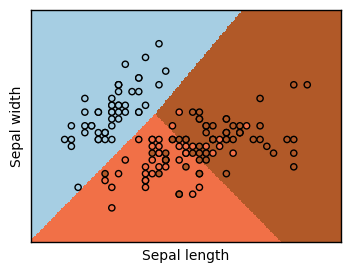